## Import the libraries

In [50]:
#data manipulation
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns

#methods and stopwords text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from wordcloud import WordCloud

#machine learning libs
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## 2. Tweets Preprocessing and Cleaning

In [51]:
train  = pd.read_csv(r'train_E6oV3lV.csv')
test = pd.read_csv(r'test_tweets_anuFYb8.csv') 

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [52]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [53]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [54]:
#to verify if null values are present

train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [55]:
test.isnull().sum()

id       0
tweet    0
dtype: int64

In [56]:
#information about rows and columns -- their datatype
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [57]:
#classifying the label and finding how many tweets are present in each label

temp = train.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet', ascending=False)  
temp

,label,tweet
0,0,29720
1,1,2242


In [58]:
train['ltweet'] = train["tweet"].apply(len)
train['ltweet'].describe()

count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: ltweet, dtype: float64

### Plotting the histogram of 'len'

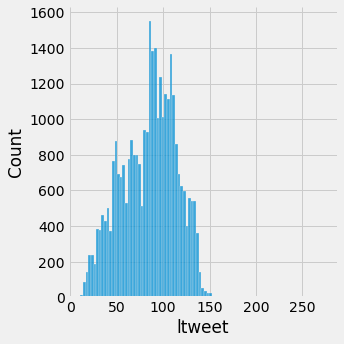

In [59]:
sns.displot(train['ltweet'])
plt.show()

### Plot the distribution of 'len' for different 'label' types

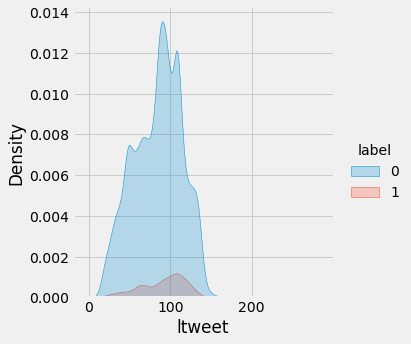

In [60]:
sns.displot(data=train, x="ltweet", hue="label", kind="kde", fill=True)
plt.show()

### Plotting the total hate and non-hate tweets

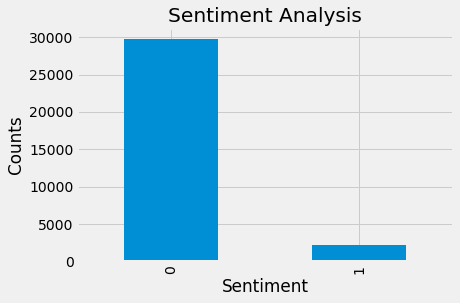

,id,label,tweet,ltweet
0,1,0.0,@user when a father is dysfunctional and is s...,102.0
1,2,0.0,@user @user thanks for #lyft credit i can't us...,122.0
2,3,0.0,bihday your majesty,21.0
3,4,0.0,#model i love u take with u all the time in ...,86.0
4,5,0.0,factsguide: society now #motivation,39.0
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,NaN
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...,NaN
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,NaN
49157,49158,NaN,"happy, at work conference: right mindset leads...",NaN


In [61]:
#show the value counts

train['label'].value_counts()

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
train['label'].value_counts().plot(kind = 'bar')
plt.show()

combine = train.append(test, ignore_index=True)
combine

In [62]:
combine.drop('ltweet',inplace=True,axis=1)

### A) Removing Twitter Handles (@user), Punctuations, Numbers, and Special Characters

In [63]:
#to remove the pattern @user from the data

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [64]:
# remove twitter handles (@user)
# tidy_tweet contains cleaned data

combine['clean_tweet'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")
combine

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,thought factory: left-right polarisation! #tru...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,"happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads..."


In [65]:
#create a function to clean the tweets

def cleanTxt(text):
    text = str(text).lower()                        #lowercase
    text = re.sub('\[.*?\]', '', text)              #text in square brackets
    text = re.sub(r'@[A-Za-z0-9]+', '',text)        #remove @mentions
    #text = re.sub(r'#', '',text)                   #Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '',text)              #Removing RT
    text = re.sub(r'https?:\/\/S+', '',text)        #Remove the hyper link
    text = re.sub('\w*\d\w*', '', text)             #Removing words containing numbers

    return text

#cleaning the text
combine['clean_tweet'] = combine['clean_tweet'].apply(cleanTxt)

#show the cleaned text
combine.head(7)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they lea...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦


In [66]:
combine['clean_tweet'] = combine['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

## Removing Stop Words

In [67]:
#removing short words

combine['clean_tweet'] = combine['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combine

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,thought factory left right polarisation #trump...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...,feeling like mermaid #hairflip #neverready #fo...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today #ohio used words li...
49157,49158,NaN,"happy, at work conference: right mindset leads...",happy work conference right mindset leads cult...


## Tokenization

In [68]:
#tokenization is the process of splitting a string of text into tokens

tokenized_tweet = combine['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

## Lemmatization

In [69]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [70]:
#lemmatization is used here inorder to get meaningful words/ stemming gives non-meaningful words

tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) #lemmatization
tokenized_tweet.head()


0    [when, father, dysfunctional, selfish, drag, k...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

clean_tweets_no_urls = pd.DataFrame(combine.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

In [71]:
#stitching the tokens back together

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['clean_tweet'] = tokenized_tweet

## Word Count distribution

In [72]:
#flat_tokens = [word for t in tokenized_tweet for word in t]

In [73]:
#len(flat_tokens)

In [74]:
#flat_tokens

## 3. Visualization from Tweets

## A) The common words used in the tweets using WordCloud

In [75]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


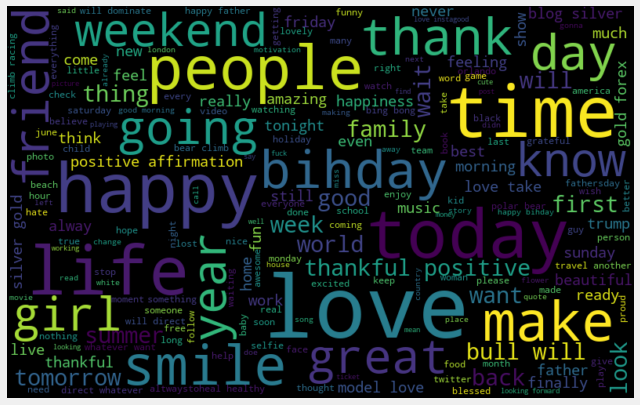

In [76]:
#understanding the common words by plotting wordclouds from overall tweets

all_words = ' '.join([text for text in combine['clean_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## B) Words in non racist/sexist tweets

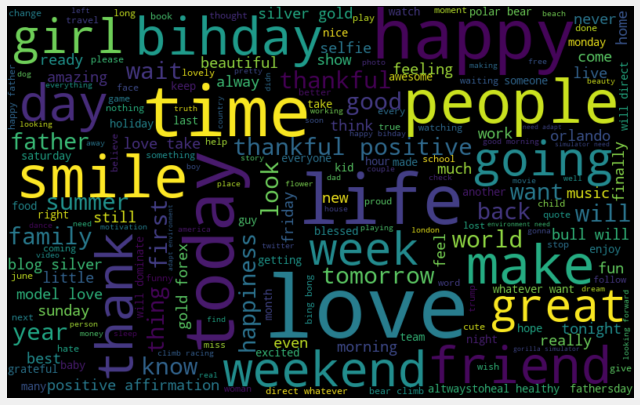

In [77]:
#Words in non racist/sexist tweets

normal_words =' '.join([text for text in combine['clean_tweet'][combine['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## C) Words in racist/sexist tweets

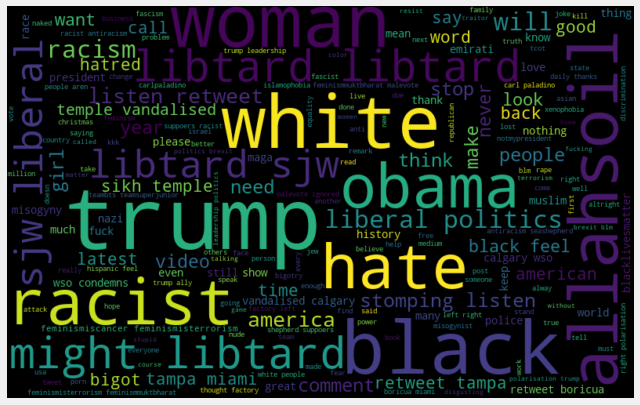

In [78]:
#Words in racist/sexist tweets

negative_words = ' '.join([text for text in combine['clean_tweet'][combine['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## D) The impact of Hashtags on tweets sentiment

In [79]:
# function to collect hashtag words

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        htg = re.findall(r"#(\w+)", i)
        hashtags.append(htg)

    return hashtags

In [80]:
# extracting the hashtag words from non racist/sexist tweets

HT_regular = hashtag_extract(combine['clean_tweet'][combine['label'] == 0])

# extracting hashtag words from racist/sexist tweets
HT_negative = hashtag_extract(combine['clean_tweet'][combine['label'] == 1])

# separating the list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

### Non-Racist/Sexist Tweets

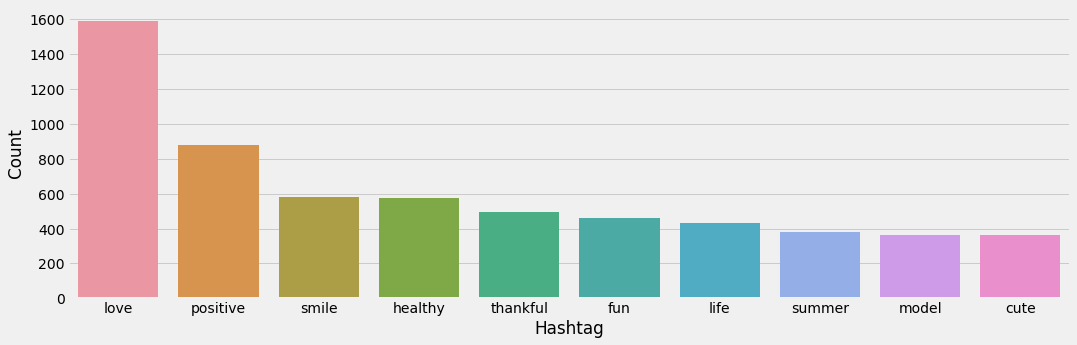

In [81]:
#non racist/sexist tweet

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting the top 10 frequently used hashtags

d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y= "Count")
ax.set(ylabel= 'Count')
plt.show()

### Racist/sexist tweets

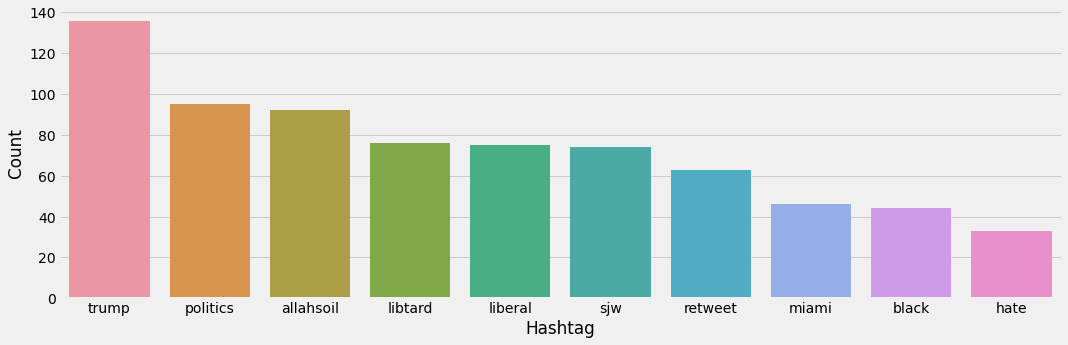

In [82]:
#racist/sexist tweets

b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

## 4. Feauture Extraction

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

In [84]:
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['clean_tweet'])
bow

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 167833 stored elements in Compressed Sparse Row format>

### TF-IDF Features

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

In [86]:
# TF-IDF feature matrix

tfidf = tfidf_vectorizer.fit_transform(combine['clean_tweet'])

## 5. Building Model: Twitter Sentiment Analysis

### Building model using TF-IDF features

In [87]:
from sklearn.metrics import f1_score

In [88]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

In [89]:
# splitting data into training and validation set

x_train_tfidf, x_test_tfidf, y_train, y_test = train_test_split(train_tfidf, train['label'], random_state=42, test_size=0.22)

In [90]:
x_train_tfidf = train_tfidf[y_train.index]
x_test_tfidf = train_tfidf[y_test.index]

In [91]:
lreg = LogisticRegression()
lreg.fit(x_train_tfidf, y_train)

LogisticRegression()

In [92]:
train_pred = lreg.predict(x_train_tfidf)

In [93]:
accuracy_score(y_train, train_pred)

0.9510629763337345

In [94]:
test_pred = lreg.predict(x_test_tfidf)
accuracy_score(y_test, test_pred)

0.9445392491467577

In [95]:
prediction = lreg.predict_proba(x_test_tfidf)
prediction_int = prediction[:,1] >= 0.22
prediction_int = prediction_int.astype(np.int)

f1_score(y_test, prediction_int)

0.548148148148148

In [96]:
test_pred     = lreg.predict_proba(test_tfidf) 
test_pred_int = test_pred[:,1] >= 0.22 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']]

In [97]:
# writing test data to a CSV file
submission.to_csv('submission_TSA.csv', index=False)

## Vectorization and Model Selection

pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Model Validation

msg_train, msg_test, label_train, label_test = train_test_split(train_tfidf, train['label'], test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))